# LA Coursework 4 ~ Code #

## Question 1 ##

### b) ###

In [16]:
import pandas as pd
from scipy.stats import ttest_ind

df = pd.read_csv('rldata_cw.csv')

# Determine the number of unique states and actions in the dataset
num_actions = df['action'].nunique()
num_states = df['state'].nunique()

# Calculate the number of pairwise state comparisons and adjust the alpha level for multiple testing
num_comparisons = num_actions * (num_states * (num_states - 1) // 2)
alpha_corrected = 0.05 / num_comparisons
print(f"Adjusted significance level with Bonferroni correction: {alpha_corrected:.8f}")

# Prepare a dictionary to store p-values for each state pair and action
p_values = {}

# Iterate over pairs of states and each action to perform t-tests
for i in range(num_states):
    for j in range(i + 1, num_states):
        pair_key = (f"{i}", f"{j}")
        p_values[pair_key] = {}
        for action in df['action'].unique():
            filter_i = (df['state'] == i) & (df['action'] == action)
            filter_j = (df['state'] == j) & (df['action'] == action)
            rewards_i = df.loc[filter_i, 'reward']
            rewards_j = df.loc[filter_j, 'reward']
            _, p_value = ttest_ind(rewards_i, rewards_j, equal_var=True)
            p_values[pair_key][action] = p_value

# Identify equivalent states by checking if all p-values exceed the corrected alpha for each pair
equivalent_states = []
tracked_states = set()

for (state_i, state_j), actions_p_values in p_values.items():
    if all(p > alpha_corrected for p in actions_p_values.values()):
        if state_i not in tracked_states:
            equivalent_group = {state_i}
            equivalent_group.add(state_j)
            tracked_states.update(equivalent_group)
            equivalent_states.append(equivalent_group)
        elif state_i in tracked_states and state_j not in tracked_states:
            for group in equivalent_states:
                if state_i in group:
                    group.add(state_j)
                    tracked_states.add(state_j)
                    break

# Output the groups of equivalent states
print("Equivalent states:")
for group in equivalent_states:
    if len(group) > 1:
        print(tuple(group))


Adjusted significance level with Bonferroni correction: 0.00002299
Equivalent states:
('16', '0', '20', '2', '25', '6', '12')
('1', '26')
('3', '9', '5')
('4', '27')
('18', '15', '11', '23', '13', '7')
('24', '8', '10')
('29', '21', '14', '28', '19')
('22', '17')


### Reducing the number of states in the dataset ###

In [17]:
df_reduced = df.copy()
final_groups = [
    {'16', '0', '20', '2', '25', '6', '12'},
    {'1', '26'},
    {'3', '9', '5'},
    {'4', '27'},
    {'18', '15', '11', '23', '13', '7'},
    {'24', '8', '10'},
    {'29', '21', '14', '28', '19'},
    {'22', '17'}
]

# Create a mapping from each state to the smallest state in its group
state_to_min_state = {}
for group in final_groups:
    min_state = min(group, key=int)  
    for state in group:
        state_to_min_state[state] = min_state

# Apply this mapping to the 'state' column in the DataFrame
df_reduced['state'] = df_reduced['state'].astype(str).map(state_to_min_state).fillna(df_reduced['state'])

df_reduced['state'] = df_reduced['state'].astype(int)
print(df_reduced)


       Unnamed: 0  stage  state  action    reward
0               0      0      0       4  0.894561
1               1      1      1       3  0.969770
2               2      2      1       4  0.621957
3               3      3      3       0  0.574317
4               4      4     14       0  1.186185
...           ...    ...    ...     ...       ...
49995       49995      0      0       3 -0.055884
49996       49996      1      0       3  0.322217
49997       49997      2      0       3  0.150933
49998       49998      3      0       3  0.910205
49999       49999      4      0       2  1.060975

[50000 rows x 5 columns]


In [18]:
states = df_reduced['state'].unique()
states

array([ 0,  1,  3, 14,  7,  4, 17,  8])

### f) ###

In [19]:
class FiniteMDP: #(R, P, initial_state_distribution, H):
    """
    Base class for a finite MDP.
    Parameters
    ----------
    R : numpy.ndarray
    P : numpy.ndarray
    initial_state_distribution : numpy.ndarray or int
        array of size (S,) containing the initial state distribution
        or an integer representing the initial/default state
    Attributes
    ----------
    R : numpy.ndarray
        array of shape (S, A) containing the mean rewards, where
        S = number of states;  A = number of actions.
    P : numpy.ndarray
        array of shape (S, A, S) containing the transition probabilities,
        where P[s, a, s'] = Prob(S_{t+1}=s'| S_t = s, A_t = a).
    """

    def __init__(self, R, Sigma2, P, p0, H, lambda_risk):
        self.p0 = p0
        S, A = R.shape
        self.S = S
        self.A = A
        self.R = R
        self.Sigma2 = Sigma2  # Variances of rewards
        self.P = P
        self.H = H
        self.reward_range = (self.R.min(), self.R.max())
        self.state = None
        self.lambda_risk = lambda_risk  # Risk sensitivity parameter
        self.States = np.arange(S)
        self.Actions = np.arange(A)

    def ResetState(self):
        """
        Reset the environment to a default state.
        """
        self.state = np.random.choice(self.States,p=self.p0)

    def Sample(self, state, action):
        """
        Modify this method to adjust the reward based on risk sensitivity.
        """
        prob = self.P[state, action, :]
        next_state = np.random.choice(self.States, p=prob)
        # Adjust reward based on risk preference
        risk_adjusted_reward = self.R[state, action] - self.lambda_risk * self.Sigma2[state, action]
        return next_state, risk_adjusted_reward

    def Play(self, action):
        next_state, reward = self.Sample(self.state, action)
        self.state = next_state
        return next_state, reward

def EstimatePhat(df, S, A):
    dfnoH = df[df.stage != 3]  

    dfnoH['state'] = pd.Categorical(dfnoH['state'], categories=range(S))
    dfnoH['action'] = pd.Categorical(dfnoH['action'], categories=range(A))
    dfnoH['nextstate'] = pd.Categorical(dfnoH['nextstate'], categories=range(S))

    # Count transitions
    N = dfnoH.groupby(['state', 'action']).size()
    M = dfnoH.groupby(['state', 'action', 'nextstate']).size().unstack(fill_value=0)

    hatP = np.zeros((S, A, S))

    for s in range(S):
        for a in range(A):
            if N.get((s, a), 0) > 0:
                transitions = M.loc[(s, a)].values
                total_transitions = transitions.sum()
                hatP[s, a, :] = transitions / total_transitions
            else:
                hatP[s, a, :] = np.zeros(S)  # No transitions observed, assume uniform or zero

    return hatP


def EstimateRhat(df, S, A):
    # Compute mean rewards and variances
    rhats = df.groupby(['state', 'action'])['reward'].mean()
    variances = df.groupby(['state', 'action'])['reward'].var().fillna(0)

    # Define estimated rewards and variances in correct shape
    hatR = np.zeros((S, A))
    hatSigma2 = np.zeros((S, A))
    for s in range(S):
        for a in range(A):
            # Use direct indexing with fallback to default if not present
            hatR[s, a] = rhats.get((s, a), 0)
            hatSigma2[s, a] = variances.get((s, a), 0)

    return hatR, hatSigma2
    
def ExpectedValue(myMDP,myPol):
    # here myPol is a collection of S dimensional probability vectors 
    H = myMDP.H
    Q = np.ones((myMDP.H, myMDP.S, myMDP.A))
    V = np.ones((myMDP.H+1, myMDP.S))
    V[H, :] = 0
    for h in range(H):
        for s in myMDP.States:
            for a in myMDP.Actions:
                Q[H-h-1,s,a] = myMDP.R[s,a] + myMDP.P[s,a,:].dot(V[H-h,:])
            
            myactionvec = myPol[H-h-1,s,:]
            V[H-h-1,s] = myactionvec.dot(Q[H-h-1,s,:])
    
    return Q, V


def EstimateMDP(df, p0, H, S, A, lambda_risk):
    # Add column which lists next state
    numobs = df.shape[0]
    nextstate = np.zeros(numobs)
    for t in range(numobs-1):
        if df['stage'][t] == H:
            nextstate[t] = 1000  # Using 1000 to denote a terminal state or similar
        else:
            nextstate[t] = df['state'][t + 1]
    nextstate[-1] = 1000

    df.insert(4, 'nextstate', nextstate, True)

    # Estimate transition probabilities and rewards
    hatP = EstimatePhat(df, S, A)
    hatR, hatSigma2 = EstimateRhat(df, S, A)

    # Create an instance of FiniteMDP with risk sensitivity parameter
    myEstMDP = FiniteMDP(hatR, hatSigma2, hatP, p0, H, lambda_risk)

    return myEstMDP

def DP(MDP):
    # Use risk-sensitive reward calculations in DP
    H, S, A = MDP.H, MDP.S, MDP.A
    Q = np.zeros((H, S, A))
    V = np.zeros((H + 1, S))
    for h in range(H-1, -1, -1):
        for s in range(S):
            for a in range(A):
                # Adjust reward calculation using lambda_risk and Sigma2
                risk_adjusted_reward = MDP.R[s, a] - MDP.lambda_risk * MDP.Sigma2[s, a]
                Q[h, s, a] = risk_adjusted_reward + np.sum(MDP.P[s, a] * V[h + 1])
            V[h, s] = np.max(Q[h, s])
    return Q, V


In [29]:
import pandas as pd
import numpy as np

# Load data
data = df_reduced

data = data.iloc[:,1:] # first column is unnamed, we can remove it]
S=8
A=5
H=5
p0 = np.ones(S)/S
# Original state to new index mapping
state_mapping = {0: 0, 1: 1, 3: 2, 7: 3, 4: 4, 8: 5, 14: 6, 17:7}
# Apply mapping to state and nextstate columns
data['state'] = data['state'].map(state_mapping)


In [30]:
myEstMDP=EstimateMDP(data,p0,H,S,A, 0.95)
P = myEstMDP.P
R = myEstMDP.R
pol,v = DP(myEstMDP)
pol

C:\Users\97258\AppData\Local\Temp\ipykernel_1688\1109555123.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfnoH['state'] = pd.Categorical(dfnoH['state'], categories=range(S))
C:\Users\97258\AppData\Local\Temp\ipykernel_1688\1109555123.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfnoH['action'] = pd.Categorical(dfnoH['action'], categories=range(A))
C:\Users\97258\AppData\Local\Temp\ipykernel_1688\1109555123.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

array([[[3.03136595, 2.82802779, 3.86435129, 3.54412684, 3.38682066],
        [3.3690901 , 2.70071062, 3.12804138, 3.096141  , 3.56663187],
        [2.93271537, 3.0319253 , 2.98836803, 2.99153582, 3.01555946],
        [3.0461377 , 3.52500155, 3.43763812, 3.28790487, 3.55273628],
        [2.86946444, 3.14138265, 3.60063876, 3.65030722, 3.21495521],
        [2.7871055 , 3.02140558, 3.01119292, 2.96423759, 3.17471268],
        [3.32426298, 2.77503128, 2.77826464, 3.36746258, 3.23576667],
        [2.79868007, 3.50834524, 3.2455369 , 3.40079507, 2.899199  ]],

       [[2.33689488, 2.17658021, 3.16605825, 2.83698946, 2.69254965],
        [2.67388444, 2.01395912, 2.43231433, 2.40630876, 2.87674303],
        [2.24703048, 2.34545379, 2.29256479, 2.29322984, 2.36340504],
        [2.36171441, 2.83591966, 2.74266718, 2.59342272, 2.85826566],
        [2.19158582, 2.45049074, 2.91494694, 2.9591954 , 2.52561031],
        [2.09681053, 2.34285386, 2.34172722, 2.27009842, 2.4809329 ],
        [2.6519145

In [53]:
v

array([[3.86435129, 3.56663187, 3.0319253 , 3.55273628, 3.65030722,
        3.17471268, 3.36746258, 3.50834524],
       [3.16605825, 2.87674303, 2.36340504, 2.85826566, 2.9591954 ,
        2.4809329 , 2.66966368, 2.8186716 ],
       [2.45618809, 2.18218859, 1.72627725, 2.15827927, 2.26333863,
        1.78589789, 1.98312864, 2.12732988],
       [1.71890386, 1.47894843, 1.11114647, 1.44804995, 1.56177903,
        1.07935603, 1.31971101, 1.43019376],
       [0.9035437 , 0.76476594, 0.53100006, 0.7507946 , 0.84949359,
        0.38914358, 0.65316858, 0.72827982],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ]])

In [52]:
# Remove the last row
v_trimmed = v[:-1]

# Compute the mean of each column
mean_values = np.mean(v_trimmed, axis=0)

print("Mean values for each column:", mean_values)

Mean values for each column: [2.42180904 2.17385557 1.75275082 2.15362515 2.25682278 1.78200861
 1.9986269  2.12256406]


In [51]:
opt_policy = np.argmax(pol, axis=2)
opt_policy

array([[2, 4, 1, 4, 3, 4, 3, 1],
       [2, 4, 4, 4, 3, 4, 3, 1],
       [2, 4, 4, 4, 3, 4, 0, 1],
       [2, 4, 4, 1, 3, 4, 0, 1],
       [2, 4, 4, 1, 3, 3, 0, 1]], dtype=int64)

### g) ###

In [32]:
pol.shape

(5, 8, 5)

In [57]:
dataPol1=np.ones((H,S,A))
dataPol1[:,:,:]=1/A
dataPol1.shape
import numpy as np

def ImportanceSampling(df, dataPol, myPol, H, S, A):
    T = int(df.shape[0] / H)  # calculate number of episodes
    Vsum = np.zeros(S)
    Weight_sum = np.zeros(S)
    total_rewards = np.array([df.reward[H * t:H * (t + 1)] for t in range(T)])
    reward_means = total_rewards.mean(axis=0)
    reward_stds = total_rewards.std(axis=0)
    
    # Function to calculate weights based on reward distributions 
    def weight_function(reward, h):
        # Normalize by subtracting mean and dividing by standard deviation
        normalized_reward = (reward - reward_means[h]) / (reward_stds[h] if reward_stds[h] > 0 else 1)
    
    # Go through all episodes
    for t in range(T):
        s = df.state[H * t]  # check initial state of the trajectory        
        # Calculate importance sampling ratio and G
        is_ratio = 1.0
        G = 0.0
        for h in range(H):
            current_state = df.state[H * t + h]
            current_action = df.action[H * t + h]
            current_reward = df.reward[H * t + h]
            policy_ratio = myPol[h, current_state, current_action] / dataPol[h, current_state, current_action]
            reward_weight = weight_function(current_reward, h)
            
            # Update importance sampling ratio with weighting function
            is_ratio *= policy_ratio * reward_weight
            G += current_reward
        
        Vsum[s] += G * is_ratio
        Weight_sum[s] += is_ratio

    Weight_sum = [w if w != 0 else 1 for w in Weight_sum]
    Vhat = Vsum / Weight_sum
    return Vhat


ImportanceSampling(data, dataPol1, pol, H, S, A)

array([4.74112387, 3.62471518, 2.41345157, 2.39498667, 3.35068437,
       6.88957118, 4.02615969, 4.52928349])

# Question 2 #

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar, minimize
from scipy.stats import norm
from numpy.random import normal
import numpy as np
from numpy.linalg import inv
from scipy.optimize import minimize_scalar
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel,ConstantKernel as C
from scipy.optimize import fminbound
from sklearn.preprocessing import StandardScaler
from functools import partial
from sklearn.gaussian_process import GaussianProcessRegressor
import scipy.optimize
from sklearn.utils.optimize import _check_optimize_result
from sklearn.gaussian_process import GaussianProcessRegressor
import scipy.optimize
import numpy as np
from numpy.linalg import inv
from sklearn.utils.optimize import _check_optimize_result
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore")

In [2]:
class GPEnv:
    def __init__(self, xmin, xmax, f, f_repr, noisevar, dim=1):
        self.var = noisevar
        self.xmin = xmin
        self.xmax = xmax
        self.f = f
        self.f_repr = f_repr  # String representation of the function
        self.xhist = np.empty(0)
        self.yhist = np.empty(0)
        if dim == 1:
            self.argmax = fminbound(lambda x: -self.f(x), xmin, xmax)
        else:
            self.dim = dim
            self.argmax = minimize(lambda x: -f(x), np.repeat((xmin + xmax) / 2, dim), bounds=(((xmin, xmax),) * dim)).x
        self.maxrew = self.f(self.argmax)
    
    def __str__(self):
        return f"Function f(x): {self.f_repr}"
    
    def meanrew(self, x):
        meanrew = self.f(x)
        return meanrew
    
    def sample(self, x):
        y = self.meanrew(x) + normal(0.0, np.sqrt(self.var))
        return x, y
    
    def update(self, x, y):
        self.xhist = np.append(self.xhist, x)
        self.yhist = np.append(self.yhist, y)
    
    def play(self, x):
        x, y = self.sample(x)
        self.update(x, y)
        return y
    
    def reset(self):
        self.xhist = np.empty(0)
        self.yhist = np.empty(0)


In [3]:
# Define the linear function and non-linear functions for the environments
f1 = lambda x: 2*x -3  # Linear increasing function
f3 = lambda x: (x - 3)**2 - 4 # Quadratic 
f4 = lambda x: x*np.sin(x)  # Simple sinusoidal function


def linear_ucb(env, t, alpha=1):  
    if env.xhist.size > 0:
        X = np.atleast_2d(env.xhist).T if env.xhist.ndim == 1 else env.xhist
        y = env.yhist[:, np.newaxis] if env.yhist.ndim == 1 else env.yhist

        # Normalize y to have mean 0 and standard deviation 1
        y_mean = np.mean(y)
        y_std = np.std(y)
        y_normalized = (y - y_mean) / y_std

        # Compute A and b for the Ridge Regression
        A = np.dot(X.T, X) + np.eye(X.shape[1])
        b = np.dot(X.T, y_normalized)

        # Calculate theta_hat using the Ridge Regression solution
        theta_hat = np.linalg.solve(A, b)

        # Generate a range of candidate x values to evaluate
        x_candidates = np.linspace(env.xmin, env.xmax, 500)
        ucbs = []
        for x in x_candidates:
            x_vector = np.array([[x]])
            pred = np.dot(theta_hat.T, x_vector) * y_std + y_mean  # Rescale prediction to original scale
            exploration = alpha * np.sqrt(np.dot(x_vector.T, np.linalg.solve(A, x_vector)))
            ucbs.append(pred + exploration)

        # Choose the x with the maximum UCB
        x_max = x_candidates[np.argmax(ucbs)]
    else:
        x_max = np.random.uniform(env.xmin, env.xmax)

    reward = env.play(x_max)
    optimal_reward = env.maxrew
    regret = optimal_reward - reward
    return reward, regret, None, env

def UCB(gp, x, T, GPEnv):
    mean, sd = gp.predict(np.array(x).reshape(-1,1), return_std=True)
    beta = np.sqrt(2*np.log(np.pi**2*(GPEnv.xmax-GPEnv.xmin)*T*len(GPEnv.yhist)**2/6)) 
    return mean + beta*sd

kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2)) + WhiteKernel(1.0)
def gp_ucb(env,T,kernel=kernel):
    env.reset()
    xmin = env.xmin
    xmax = env.xmax
    gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-5, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=5, normalize_y=True)

    # first sample must be random
    x = np.random.uniform(xmin,xmax)
    y = env.play(x)
    cumulative_reward = []
    cumulative_regret = []
    rew = np.zeros(T) 
    reg = np.zeros(T) 
    rew[0] = y
    reg[0] = env.maxrew - env.f(x)

    
    for t in range(1,T):
        if env.xhist.size > 0:
            gp.fit(env.xhist.reshape(-1, 1), env.yhist)        
        myx = fminbound(lambda x: -UCB(gp,x,T,env),xmin,xmax)
        y = env.play(myx)
        rew[t] = y
        reg[t] = env.maxrew - env.f(myx)
        cumulative_reward.append(np.cumsum(rew))
        cumulative_regret.append(np.cumsum(reg))
    return cumulative_reward, cumulative_regret, gp, env


def gp_ts(env, T, kernel=kernel):
    env.reset()
    xmin = env.xmin
    xmax = env.xmax
    gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-5, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=5, normalize_y=True)

    # first sample must be random
    x = np.random.uniform(xmin,xmax)
    y = env.play(x)
    cumulative_reward = []
    cumulative_regret = [] 
    rew = np.zeros(T) 
    reg = np.zeros(T) 
    rew[0] = y
    reg[0] = env.maxrew - env.f(x)
    
    #define set over which we search for the best action
    search_set = np.linspace(env.xmin,env.xmax,100)
    
    
    for t in range(1,T):
        if env.xhist.size > 0:
            gp.fit(env.xhist.reshape(-1, 1), env.yhist)
        posterior_sample = gp.sample_y(search_set.reshape(-1, 1))[:,0]
        #play x with the largest function value
        myx_index = np.argmax(posterior_sample)
        myx = search_set[myx_index]
        y = env.play(myx)
        rew[t] = y
        reg[t] = env.maxrew - env.f(myx)
        cumulative_reward.append(np.cumsum(rew))
        cumulative_regret.append(np.cumsum(reg))
    return cumulative_reward,cumulative_regret,gp,env


def simulate_lin_ucb(env, algo, rounds):
    env.reset()
    cumulative_reward = []
    cumulative_regret = [] 
    reward = np.zeros(rounds) 
    regret = np.zeros(rounds) 
    for t in range(1, rounds+1):
        reward[t-1], regret[t-1], model, env = algo(env, t)
        cumulative_reward.append(np.cumsum(reward))
        cumulative_regret.append(np.cumsum(regret))
    return cumulative_reward, cumulative_regret, model, env

def simulate_ts_ucb(env,algo,rounds):
    reward, regret, model, env = algo(env, rounds)
    return reward, regret, model, env



rounds = 20
rewards = {}
regrets = {}
models = {}
env_ = {}
print('2x - 3')
rewards[f'Env 1 Linear-UCB'], regrets[f'Env 1 Linear-UCB'], _, env_[f'Env 1 Linear-UCB'] = simulate_lin_ucb(GPEnv(0, 10, f1,'3x+1', 0.1), linear_ucb, rounds)
rewards[f'Env 1 GP-TS'], regrets[f'Env 1 GP-TS'],  models[f'Env 1 GP-TS'], env_[f'Env 1 GP-TS'] = simulate_ts_ucb(GPEnv(0, 10, f1,'3x+1', 0.1), gp_ts, rounds)
rewards[f'Env 1 GP-UCB'], regrets[f'Env 1 GP-UCB'], models[f'Env 1 GP-UCB'], env_[f'Env 1 GP-UCB']= simulate_ts_ucb(GPEnv(0, 10, f1,'3x+1', 0.1), gp_ucb, rounds)
print('(x-3)^2 - 4')
rewards[f'Env 2 Linear-UCB'], regrets[f'Env 2 Linear-UCB'], _, env_[f'Env 2 Linear-UCB'] = simulate_lin_ucb(GPEnv(0, 10, f3,'(x-3)**2 -4', 0.1), linear_ucb, rounds)
rewards[f'Env 2 GP-TS'], regrets[f'Env 2 GP-TS'],  models[f'Env 2 GP-TS'], env_[f'Env 2 GP-TS'] = simulate_ts_ucb(GPEnv(0, 10, f3,'(x-3)**2 -4', 0.1), gp_ts, rounds)
rewards[f'Env 2 GP-UCB'], regrets[f'Env 2 GP-UCB'], models[f'Env 2 GP-UCB'], env_[f'Env 2 GP-UCB']= simulate_ts_ucb(GPEnv(0, 10, f3,'(x-3)**2 -4', 0.1), gp_ucb, rounds)
print('x * sin(x)')
rewards[f'Env 3 Linear-UCB'], regrets[f'Env 3 Linear-UCB'], _, env_[f'Env 3 Linear-UCB'] = simulate_lin_ucb(GPEnv(0, 10, f4,'xsin(x)', 0.1), linear_ucb, rounds)
rewards[f'Env 3 GP-TS'], regrets[f'Env 3 GP-TS'],  models[f'Env 3 GP-TS'], env_[f'Env 3 GP-TS'] = simulate_ts_ucb(GPEnv(0, 10, f4,'xsin(x)', 0.1), gp_ts, rounds)
rewards[f'Env 3 GP-UCB'], regrets[f'Env 3 GP-UCB'], models[f'Env 3 GP-UCB'], env_[f'Env 3 GP-UCB']= simulate_ts_ucb(GPEnv(0, 10, f4,'xsin(x)', 0.1), gp_ucb, rounds)


2x - 3
(x-3)^2 - 4
x * sin(x)


In [4]:
print(np.mean(regrets[f'Env 1 Linear-UCB'], axis = 0))

[ 8.03333095 26.96468942 26.5400876  26.68738051 26.31668202 25.66846877
 25.5653297  25.78969474 26.21476309 26.32806395 26.38897376 26.35273713
 26.19843858 26.13261885 26.25046074 26.27343499 26.31726658 26.29398485
 26.3114326  26.29504296]


## plots ##

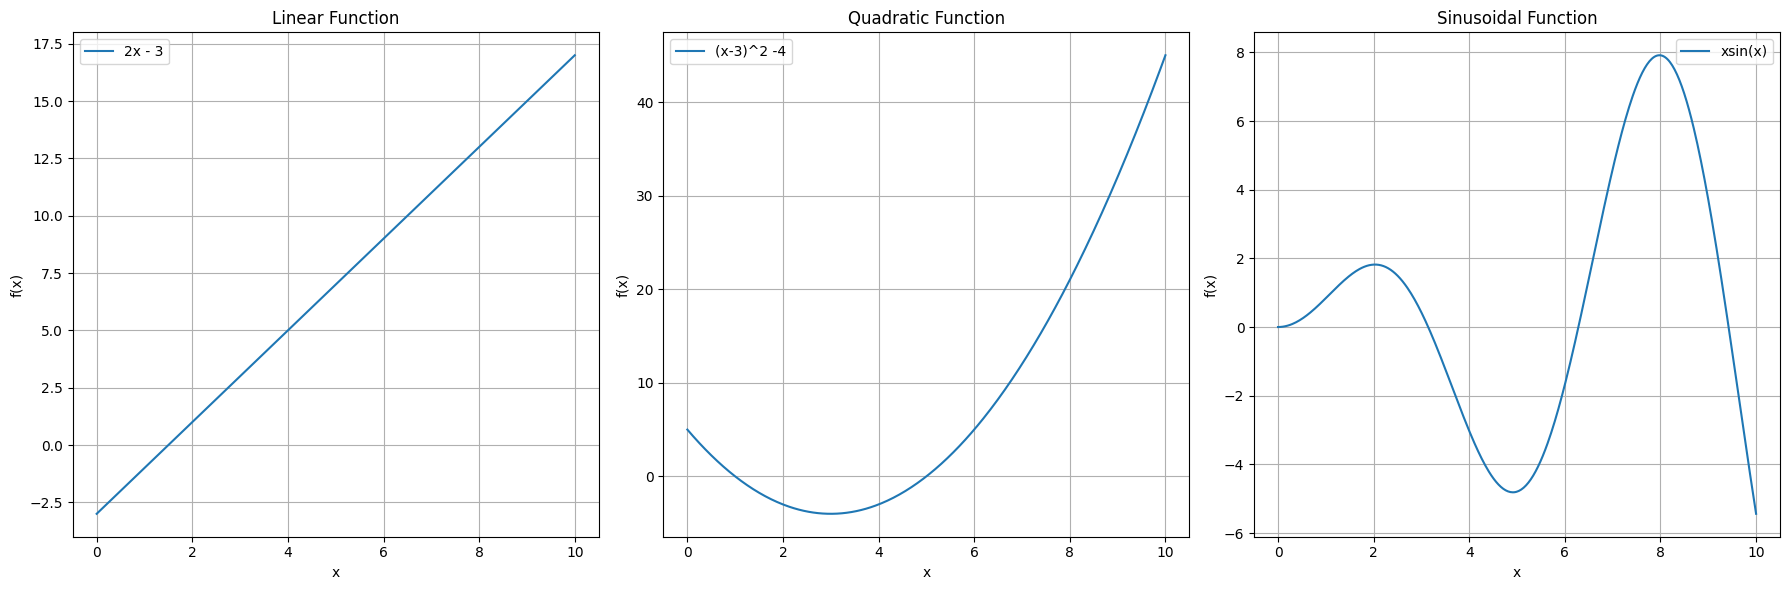

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# # Define the functions
# f1 = lambda x: x + 4 # Linear increasing function
# f3 = lambda x: (x-3)**2 -4  # Quadratic with minimum at -1
# f4 = lambda x: x* np.sin(x)  # Simple sinusoidal function

# Create a range of x values for each function
x1 = np.linspace(0, 10, 400)
x2 = np.linspace(0, 10, 400)
x3 = np.linspace(0, 10, 400)

# Compute the y values for each function
y1 = f1(x1)
y3 = f3(x2)
y4 = f4(x3)

# Plotting
plt.figure(figsize=(18, 6))

# Plot for f1
plt.subplot(1, 3, 1)
plt.plot(x1, y1, label='2x - 3')
plt.title('Linear Function')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)
plt.legend()

# Plot for f3
plt.subplot(1, 3, 2)
plt.plot(x2, y3, label='(x-3)^2 -4')
plt.title('Quadratic Function')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)
plt.legend()

# Plot for f4
plt.subplot(1, 3, 3)
plt.plot(x3, y4, label='xsin(x)')
plt.title('Sinusoidal Function')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


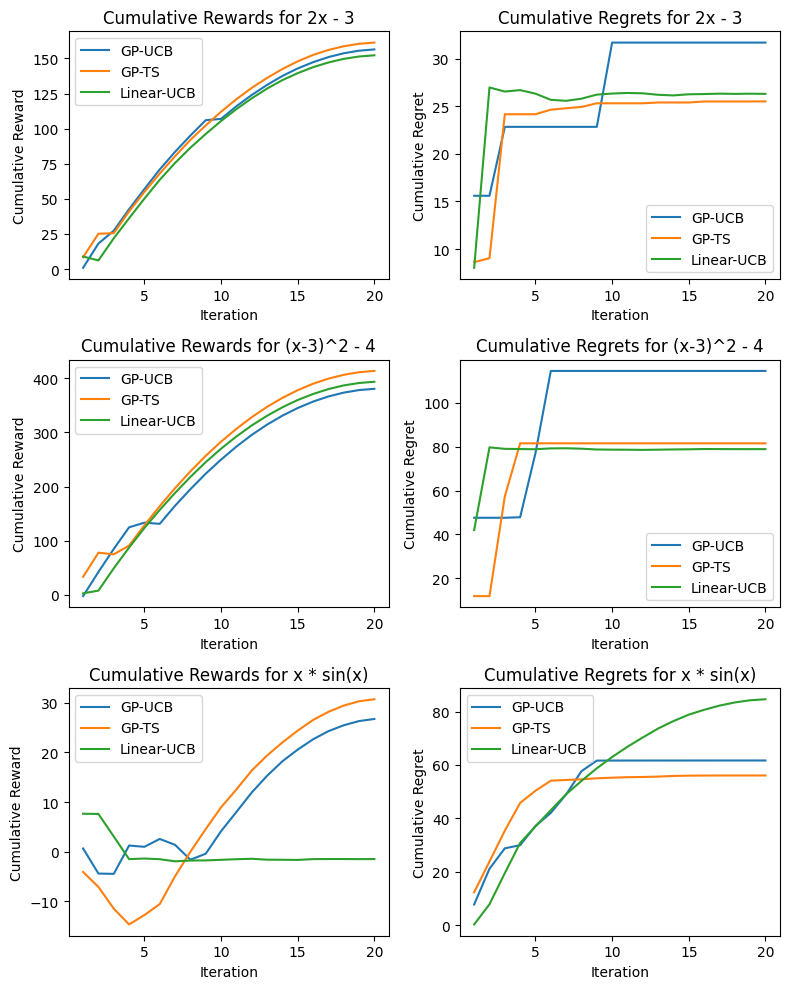

In [6]:
import numpy as np
import matplotlib.pyplot as plt

models_lst = ['GP-UCB', 'GP-TS', 'Linear-UCB']  # List of algorithms
envs = ['Env 1', 'Env 2', 'Env 3']
functions = ['2x - 3', '(x-3)^2 - 4', 'x * sin(x)']

# Create figure and axes
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 10))

# Loop through each environment (function)
for i, env in enumerate(envs):
    for j, model in enumerate(models_lst):
        key = f'{env} {model}'

        # Plot cumulative rewards in the left column
        ax1 = axes[i, 0]
        ax1.plot(range(1, rounds+1), np.mean(rewards[key], axis = 0), label=f'{model}')
        ax1.set_title(f'Cumulative Rewards for {functions[i]}')
        ax1.set_xlabel('Iteration')
        ax1.set_ylabel('Cumulative Reward')
        ax1.legend()

        # Plot cumulative regrets in the right column
        ax2 = axes[i, 1]
        ax2.plot(range(1, rounds+1), np.mean(regrets[key], axis = 0), label=f'{model}')
        ax2.set_title(f'Cumulative Regrets for {functions[i]}')
        ax2.set_xlabel('Iteration')
        ax2.set_ylabel('Cumulative Regret')
        ax2.legend()

plt.tight_layout()
plt.show()


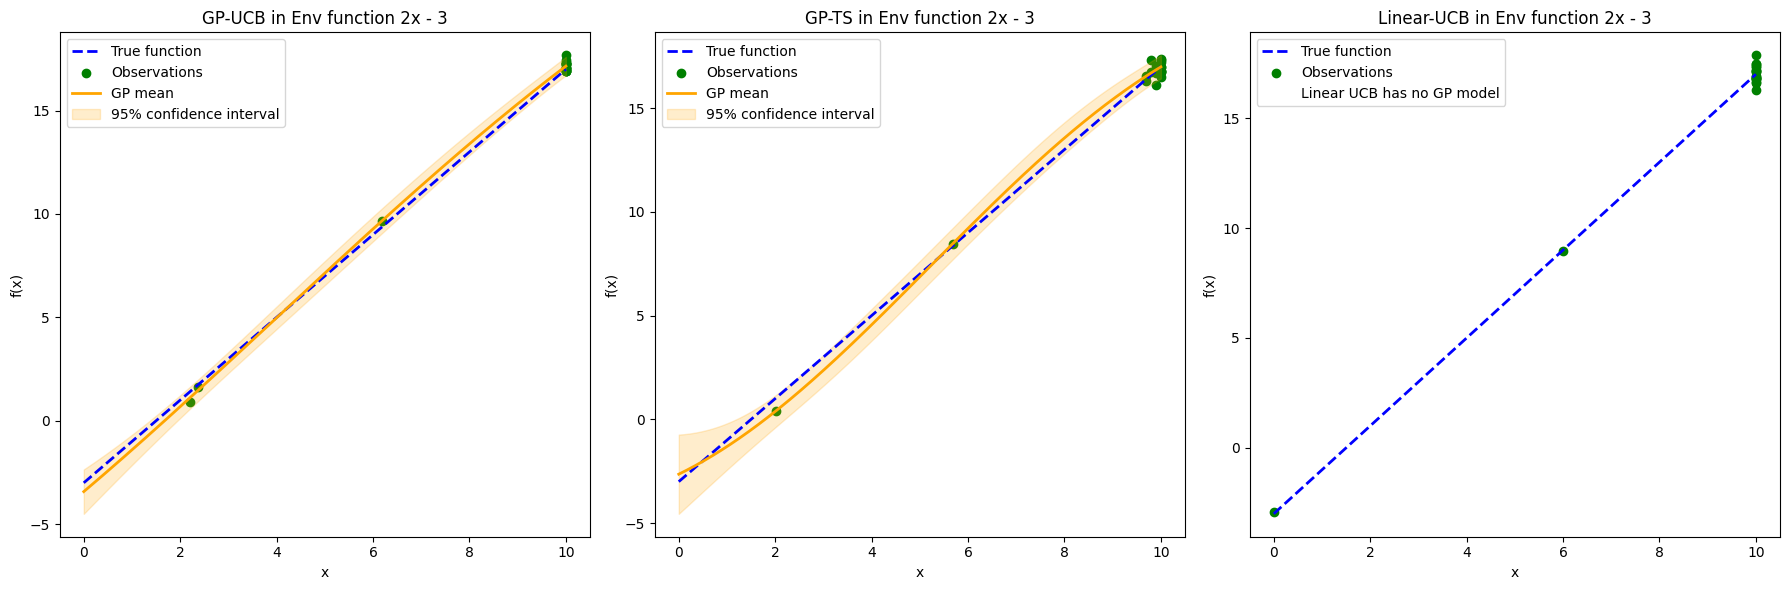

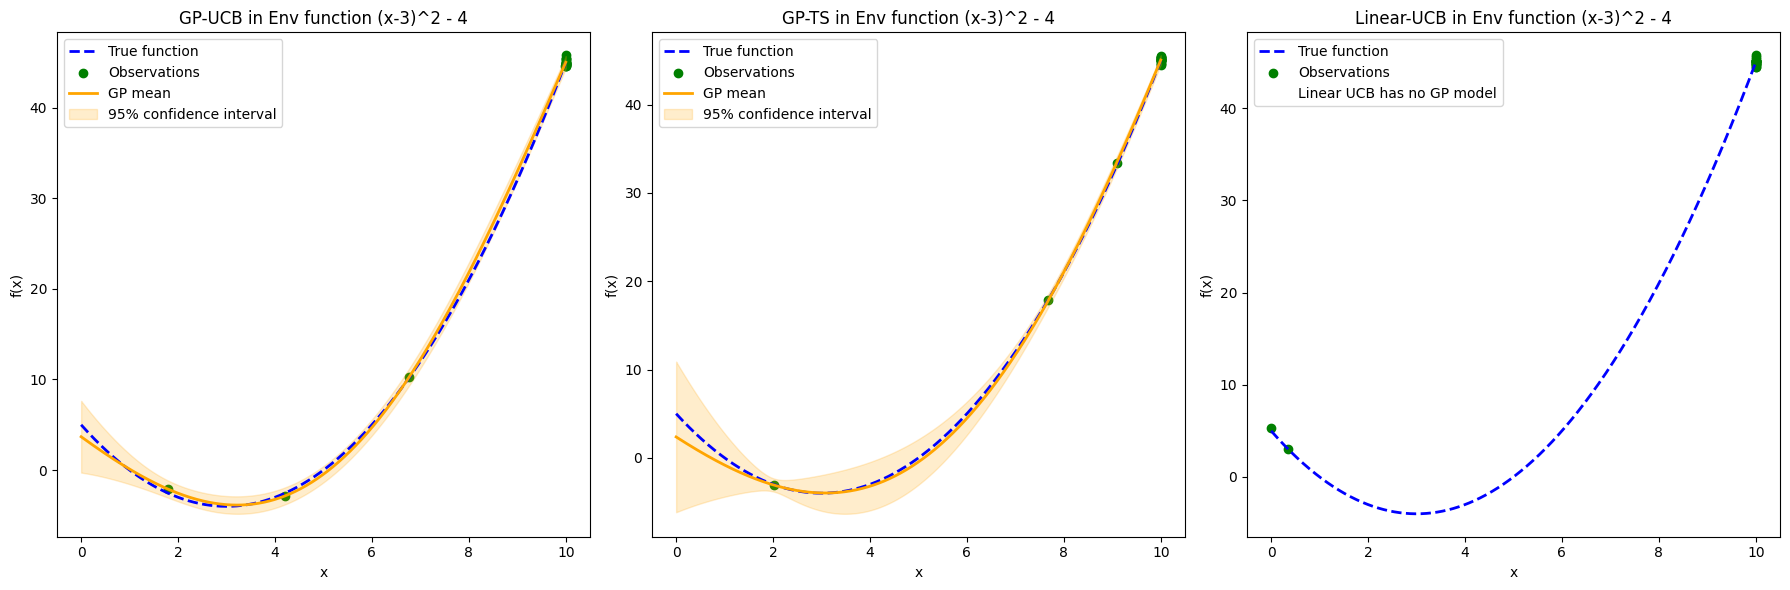

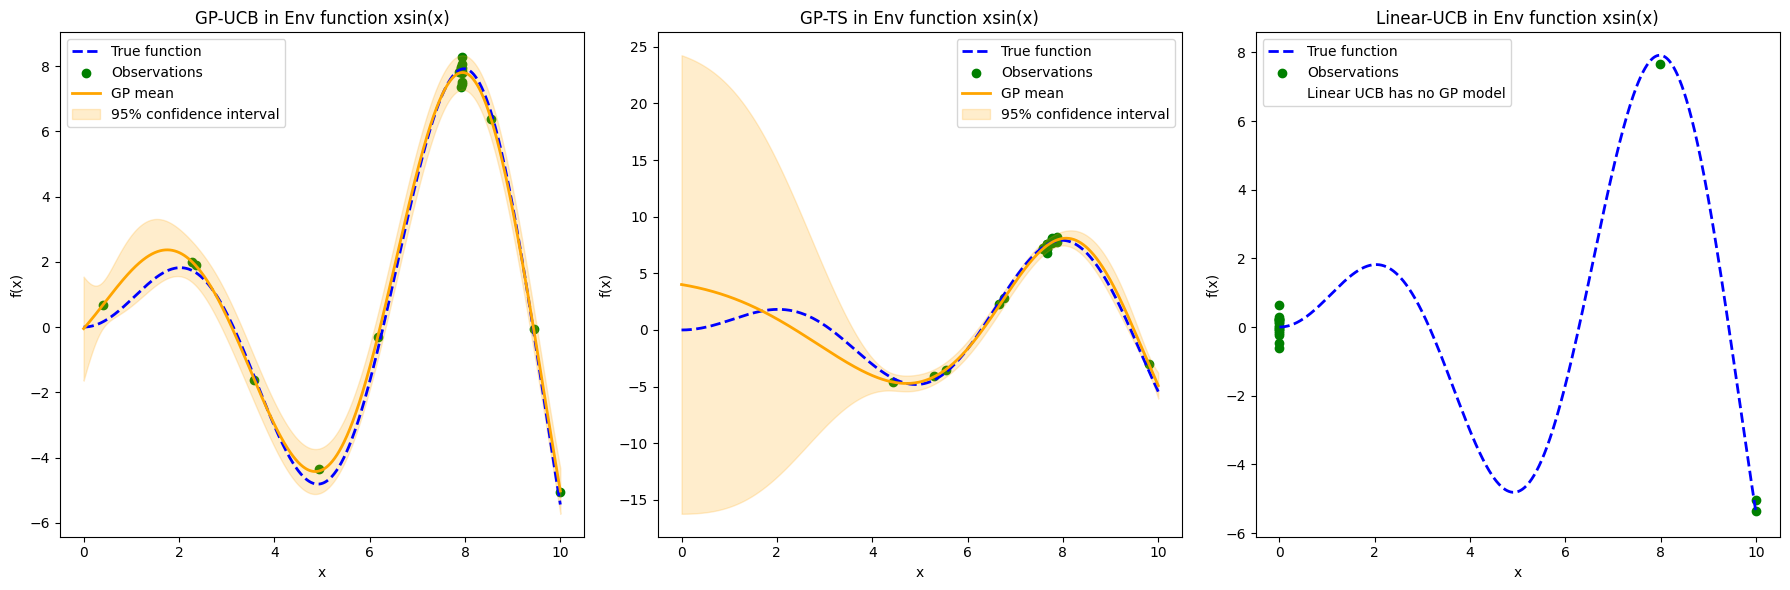

In [9]:
import numpy as np
import matplotlib.pyplot as plt

models_lst = ['GP-UCB', 'GP-TS', 'Linear-UCB']  
functions = ['2x - 3', '(x-3)^2 - 4', 'xsin(x)']

for i in range(1, len(env_) // 3 + 1):
    plt.figure(figsize=(18, 6)) 

    for j, algo in enumerate(models_lst):
        key = f'Env {i} {algo}'
        env = env_[key]

        x_range = np.linspace(env.xmin, env.xmax, 1000)
        y_true = np.array([env.f(xi) for xi in x_range])

        ax = plt.subplot(1, 3, j+1)  

        # Plot the true function in blue
        ax.plot(x_range, y_true, 'b--', lw=2, label='True function')

        # Observations from the environment in green
        ax.scatter(env.xhist, env.yhist, c='g', label='Observations')

        if algo != 'Linear-UCB':  # Check if model predictions are needed
            model = models[key]
            mu, sigma = model.predict(x_range.reshape(-1, 1), return_std=True)
            # Plot GP mean in orange and confidence interval
            ax.plot(x_range, mu, 'orange', lw=2, label='GP mean')
            ax.fill_between(x_range, mu - 1.96 * sigma, mu + 1.96 * sigma, alpha=0.2, color='orange', label='95% confidence interval')
        else:
            # For Linear-UCB, no model predictions are shown
            ax.plot([], [], ' ', label='Linear UCB has no GP model')  

        # Set common labels and title for each subplot
        ax.set_xlabel('x')
        ax.set_ylabel('f(x)')
        ax.set_title(f'{algo} in Env function {functions[i-1]}')
        ax.legend()

    plt.tight_layout()
    plt.show()
